PyTorch version: 2.2.1+cu121
CUDA available: True
CUDA version: 12.1
Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU
Training Forward Model
Epoch 0, Loss: 2.2237
Epoch 100, Loss: 0.1904
Epoch 200, Loss: 0.0862
Epoch 300, Loss: 0.0706
Epoch 400, Loss: 0.0600
Epoch 500, Loss: 0.0507
Epoch 600, Loss: 0.0415
Epoch 700, Loss: 0.0318
Epoch 800, Loss: 0.0225
Epoch 900, Loss: 0.0153
Epoch 1000, Loss: 0.0109
Epoch 1100, Loss: 0.0085
Epoch 1200, Loss: 0.0070
Epoch 1300, Loss: 0.0061
Epoch 1400, Loss: 0.0055
Epoch 1500, Loss: 0.0051
Epoch 1600, Loss: 0.0049
Epoch 1700, Loss: 0.0046
Epoch 1800, Loss: 0.0045
Epoch 1900, Loss: 0.0043
Epoch 2000, Loss: 0.0042
Epoch 2100, Loss: 0.0041
Epoch 2200, Loss: 0.0040
Epoch 2300, Loss: 0.0039
Epoch 2400, Loss: 0.0038
Epoch 2500, Loss: 0.0037
Epoch 2600, Loss: 0.0036
Epoch 2700, Loss: 0.0035
Epoch 2800, Loss: 0.0035
Epoch 2900, Loss: 0.0034
Epoch 3000, Loss: 0.0033
Epoch 3100, Loss: 0.0033
Epoch 3200, Loss: 0.0032
Epoch 3300, Loss: 0.0031
Epoch 3400

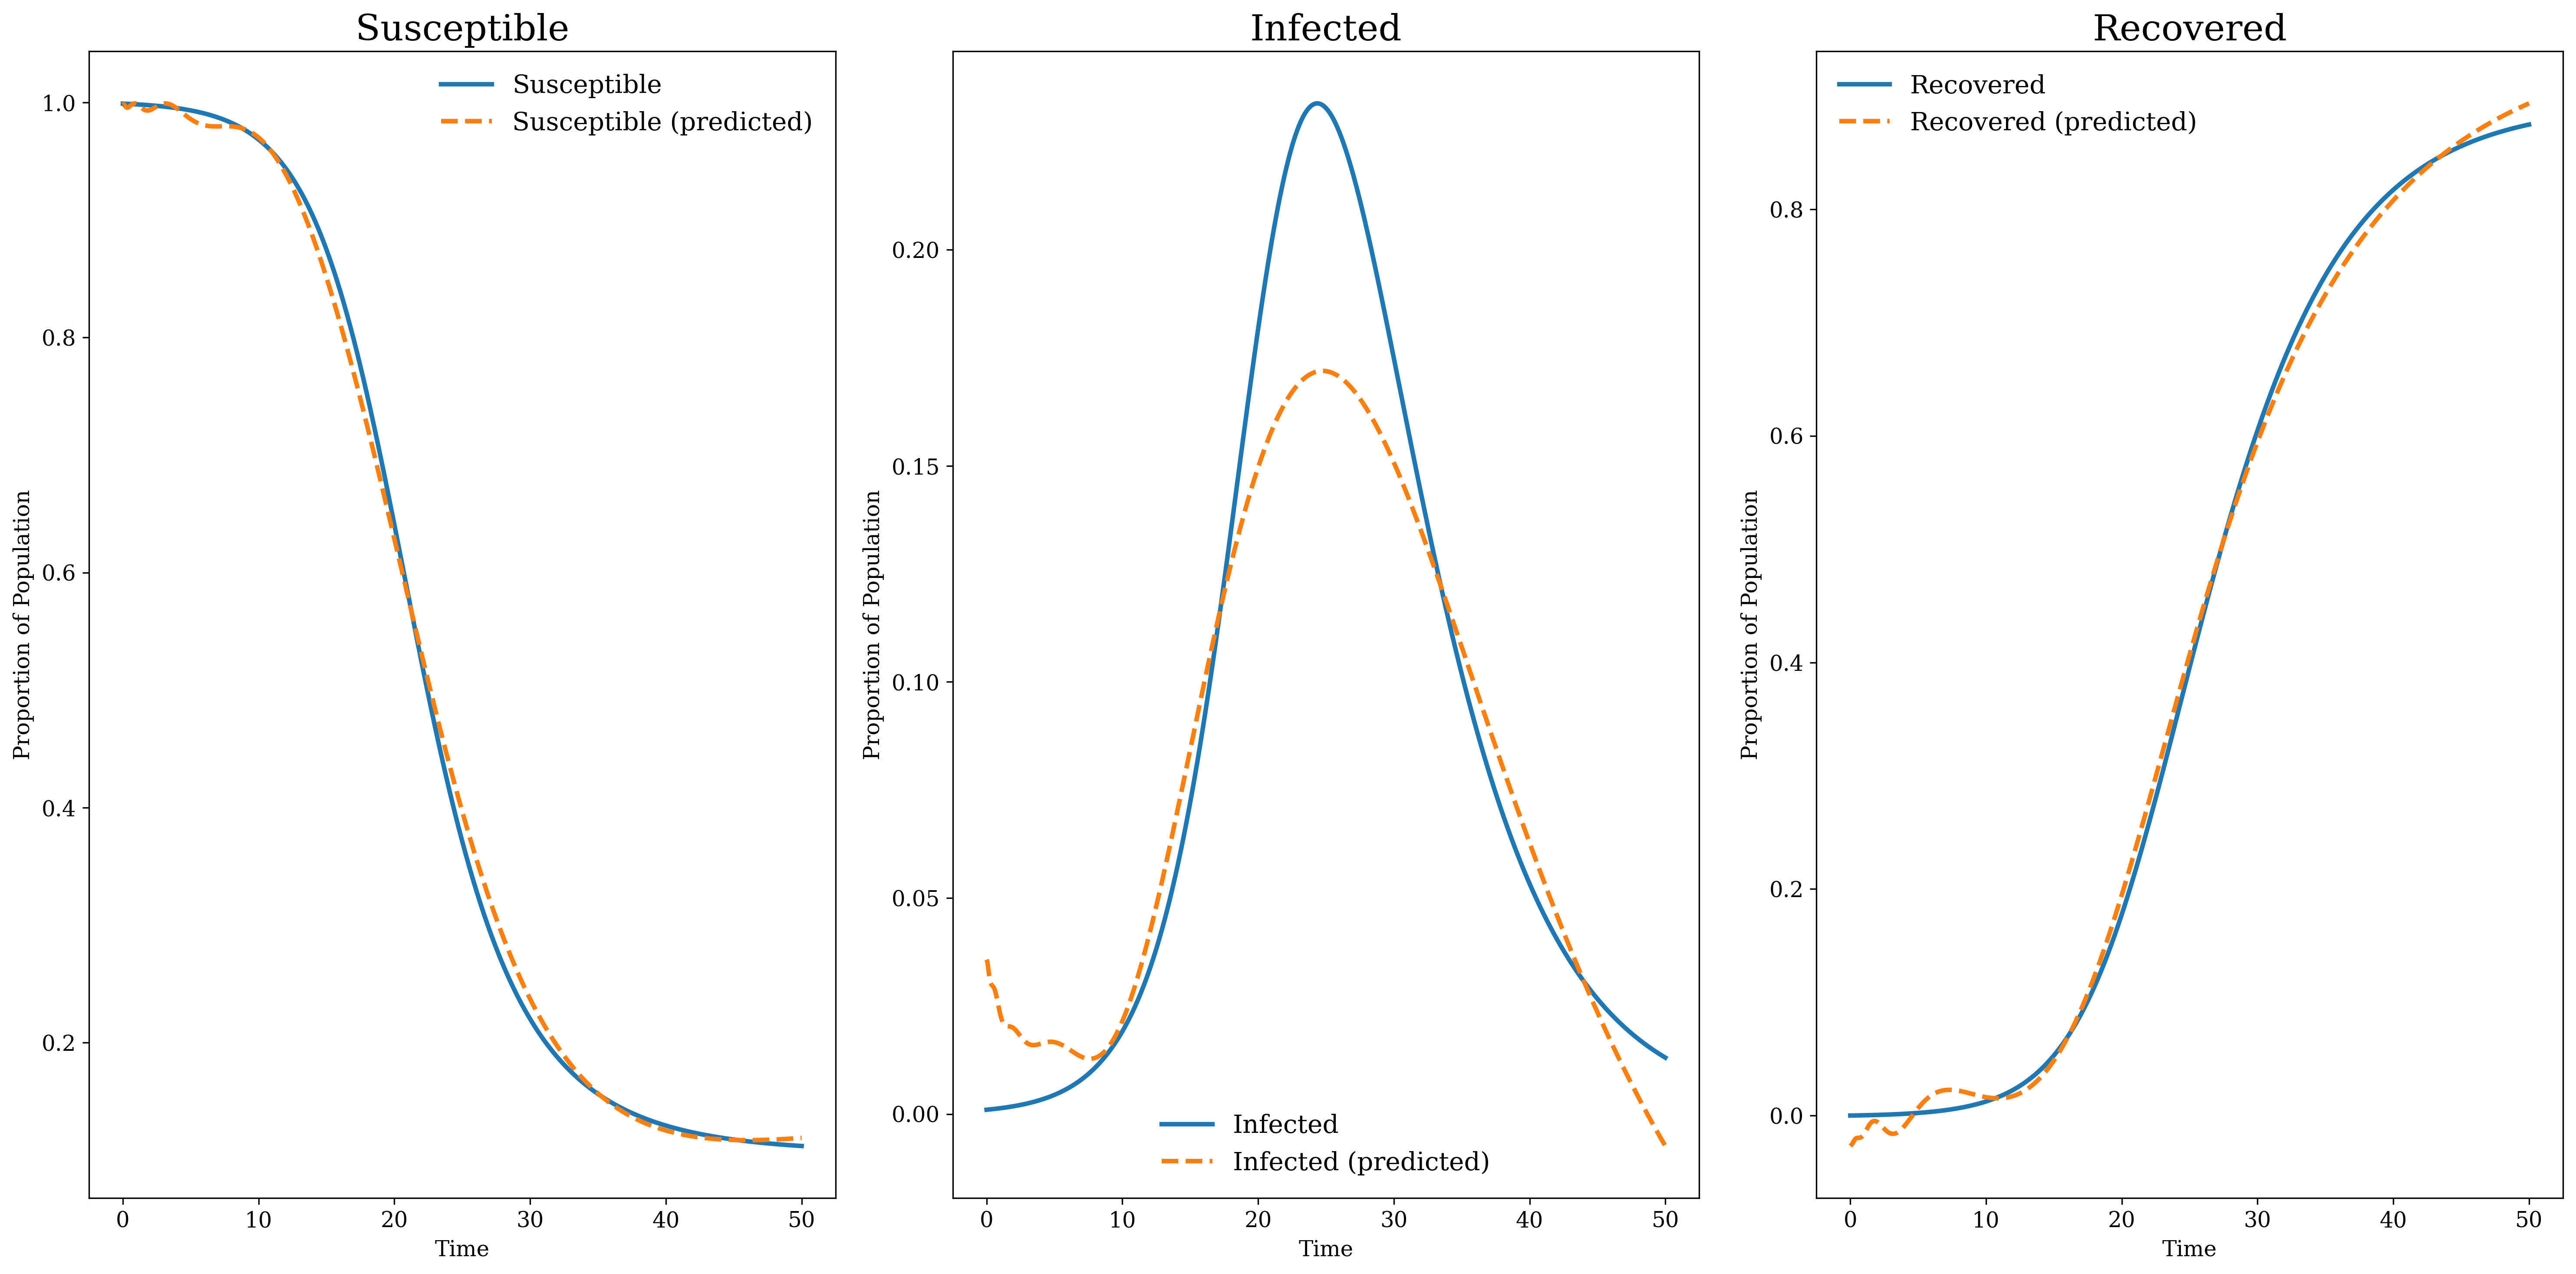

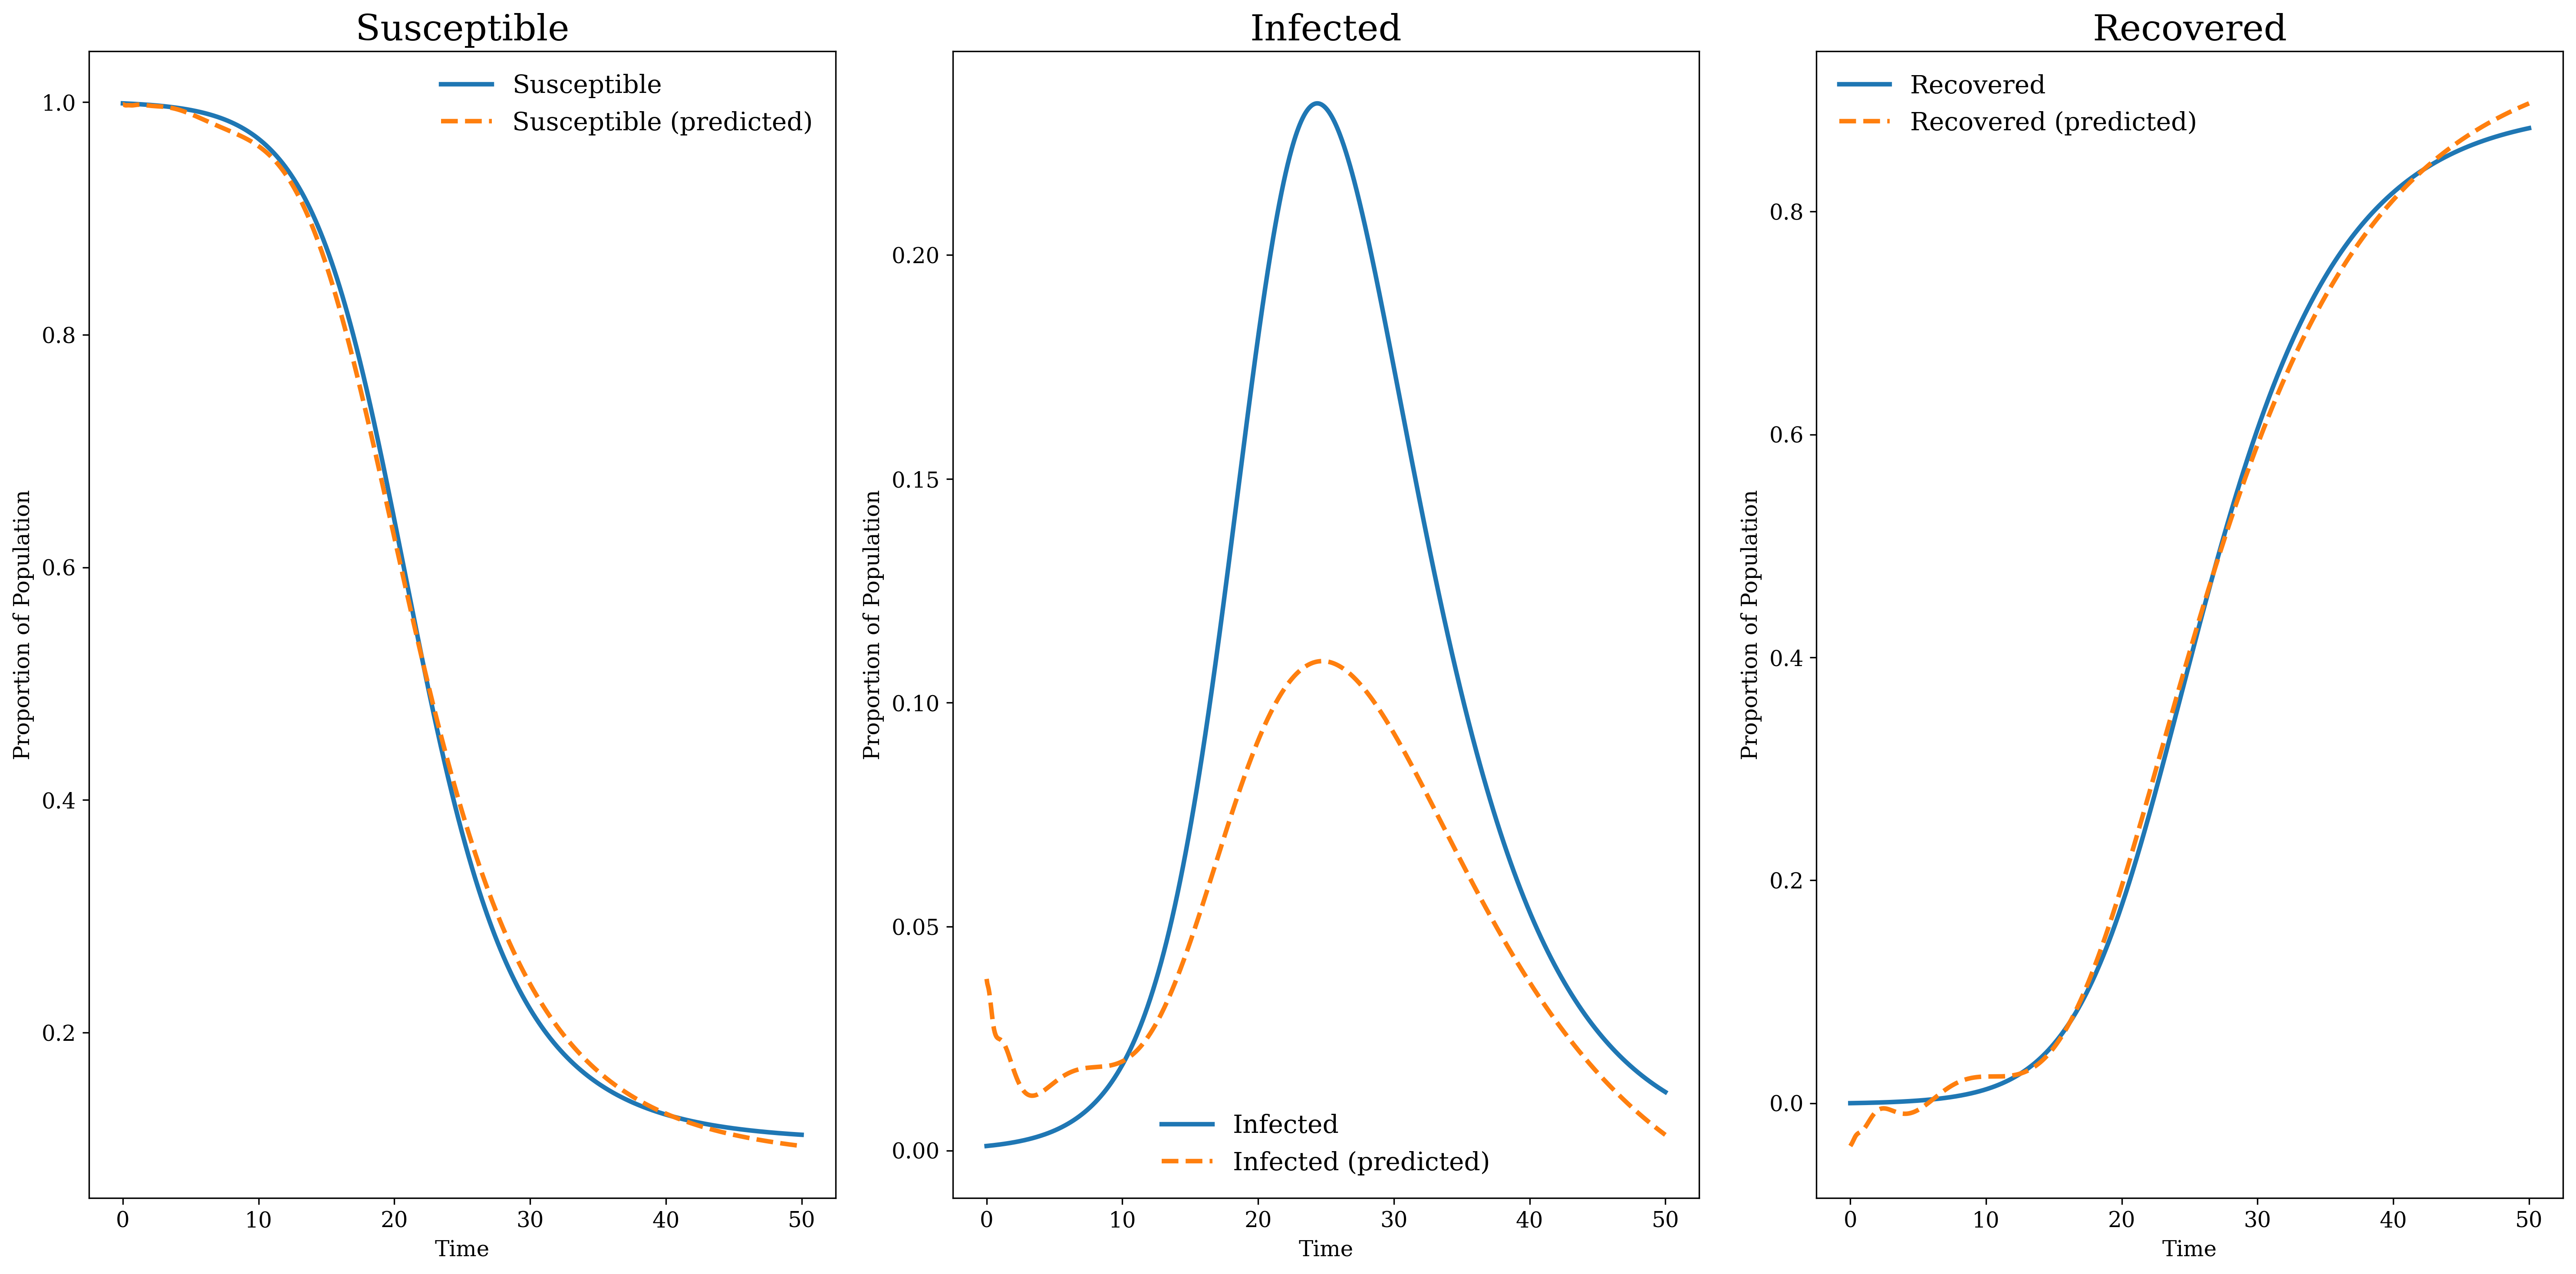

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.integrate import solve_ivp, odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set up matplotlib
plt.rcParams.update({
    # Font settings for clarity and compatibility with academic publications
    "font.family": "serif",  # Consistent font family
    # "font.serif": ["Times", "Computer Modern Roman"],  # Preferred serif fonts
    "font.size": 14,  # Base font size for better readability
    "text.usetex": False,  # Enable LaTeX for text rendering for a professional look

    # Figure aesthetics & size for detailed visuals and fit on publication pages
    "figure.figsize": (8, 5),  # Adjusted figure size for a balance between detail and fit
    "figure.facecolor": "white",  # White figure background for clean print
    "figure.autolayout": True,  # Enable automatic layout adjustments
    "figure.dpi": 400,  # High resolution figures
    "savefig.dpi": 400,  # High resolution saving settings
    "savefig.format": "pdf",  # Save figures in PDF format for publications
    "savefig.bbox": "tight",  # Tight bounding box around figures

    # Axes aesthetics for clarity and precision
    "axes.labelsize": 14,  # Clear labeling with larger font size
    "axes.titlesize": 20,  # Prominent titles for immediate recognition
    "axes.facecolor": "white",  # White axes background

    # Legend aesthetics for distinguishing plot elements
    "legend.fontsize": 12,  # Readable legend font size
    "legend.frameon": False,  # No frame around legend for cleaner look
    "legend.loc": "best",  # Optimal legend positioning

    # Line aesthetics for clear visual distinctions
    "lines.linewidth": 2,  # Thicker lines for visibility
    "lines.markersize": 8,  # Slightly smaller markers for balance

    # Tick label sizes for readability
    "xtick.labelsize": 12, 
    "ytick.labelsize": 12,
    "xtick.direction": "in",  # Ticks inside the plot
    "ytick.direction": "in",  # Ticks inside the plot
})

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("../../data/processed/england_data.csv")

params = {
    "alpha": 0.1,   # Rate of transmission from the infected not requiring hospitalization
    "beta": 0.17,   # Rate of transmission from the infected requiring hospitalization
    "gamma": 1 / 16,# Recovery rate
    "theta": 0.001, # Mortality rate
    "N": 56171302,  # Total population for England
    # Parameters for hospitalized and critical
    "rho": 0.05,    # Hospitalization rate for infected
    "delta": 0.01,  # Mortality rate for non-hospitalized
    "eta": 0.02,    # Rate at which hospitalized become critical
    "kappa": 0.03,  # Recovery rate for hospitalized
    "mu": 0.01,     # Recovery rate for critical
    "xi": 0.005     # Mortality rate for critical
}

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [56171302 - 20, 20, 0, 0, 0, 0]


def sihcrd_model(t, y, params):
    S, I, H, C, R, D = y
    N = params["N"]
    dSdt = -(params["beta"] * I / N + params["alpha"] * I / N) * S
    dIdt = (params["beta"] * I / N + params["alpha"] * I / N) * S - params["gamma"] * I - params["rho"] * I - params["delta"] * I
    dHdt = params["rho"] * I - params["eta"] * H - params["kappa"] * H
    dCdt = params["eta"] * H - params["mu"] * C - params["xi"] * C
    dRdt = params["gamma"] * I + params["kappa"] * H + params["mu"] * C
    dDdt = params["delta"] * I + params["xi"] * C
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


# Time points (in days) for simulation
t_span = (0, 160)  # Simulation period in days
t_eval = np.linspace(t_span[0], t_span[1], 160)  # Time points to evaluate

# Integrate the SIHCRD equations over the time grid
solution = solve_ivp(sihcrd_model, t_span, initial_conditions, args=(params,), t_eval=t_eval)

# Plotting the SIHCRD model outcomes
plt.figure(figsize=(12, 8))
labels = ['Susceptible', 'Infected', 'Hospitalized', 'Critical', 'Recovered', 'Deceased']
for i, label in enumerate(labels):
    plt.plot(solution.t, solution.y[i], label=label)

plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.legend()
plt.title('SIHCRD Model Simulation for England')
plt.show()



def load_and_preprocess_data(filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date", "cumulative_confirmed", "cumulative_deceased",
        "population", "covidOccupiedMVBeds", "hospitalCases"
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # Apply rolling average
    for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds"]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]

    # Estimate the susceptible population
    df["S(t)"] = df["population"] - df["active_cases"] - df["recovered"] - df["cumulative_deceased"]

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[["recovered", "active_cases", "S(t)"]].clip(lower=0)

    return df


def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        train_size (float): Proportion of the dataset to allocate to training.
        val_size (float): Proportion of the dataset to allocate to validation.
        test_size (float): Proportion of the dataset to allocate to testing.

    Returns:
        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data


data = load_and_preprocess_data("../../data/processed/england_data.csv", recovery_period=21, rolling_window=7, start_date="2020-04-01")

# Standardize the data
# data["cumulative_confirmed"] = data["cumulative_confirmed"] / data["population"]
# data["cumulative_deceased"] = data["cumulative_deceased"] / data["population"]
# data["covidOccupiedMVBeds"] = data["covidOccupiedMVBeds"] / data["population"]
# data["active_cases"] = data["active_cases"] / data["population"]
# data["hospitalCases"] = data["hospitalCases"] / data["population"]
# data["recovered"] = data["recovered"] / data["population"]

# split data
train_data, val_data, test_data = split_time_series_data(data, train_size=0.7, val_size=0.15, test_size=0.15)


train_data = train_data[["days_since_start", "cumulative_confirmed", "cumulative_deceased", "covidOccupiedMVBeds", "hospitalCases", "recovered", "active_cases", "S(t)"]]

plt.figure(figsize=(12, 6))
plt.plot(train_data["days_since_start"], train_data["cumulative_confirmed"], label="Confirmed Cases")

plt.xlabel("Days Since Start")
plt.ylabel("Proportion of Population")
plt.title("Confirmed and Deceased Cases Over Time")
plt.legend()
plt.show()

t_train = torch.tensor(train_data["days_since_start"].values, dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
S_train = torch.tensor(train_data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
I_train = torch.tensor(train_data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
R_train = torch.tensor(train_data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
D_train = torch.tensor(train_data["cumulative_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
H_train = torch.tensor(train_data["hospitalCases"].values, dtype=torch.float32).view(-1, 1).to(device)
C_train = torch.tensor(train_data["covidOccupiedMVBeds"].values, dtype=torch.float32).view(-1, 1).to(device)

# Combining all compartments to form the training dataset for the model
SIHCRD_train = torch.cat([S_train, I_train, H_train, C_train, R_train, D_train], dim=1).to(device)


class SIHCRDNet(nn.Module):
    def __init__(self, inverse=False, init_params=None, retrain_seed=42, num_layers=4, hidden_neurons=20):
        super(SIHCRDNet, self).__init__()
        self.retrain_seed = retrain_seed
        self.inverse = inverse
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers.append(nn.Linear(hidden_neurons, 6))  # Output layer for S, I, H, C, R, D
        self.net = nn.Sequential(*layers)

        if inverse:
            # Assuming init_params is a dictionary with keys 'beta', 'gamma', 'rho', 'eta', 'theta'
            default_values = torch.rand(5)
            self.params = nn.Parameter(torch.tensor([init_params.get(k, default_values[i]) for i, k in enumerate(['beta', 'gamma', 'rho', 'eta', 'theta'])], device='cuda' if torch.cuda.is_available() else 'cpu'), requires_grad=True)
        else:
            self.params = None

        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    @property
    def beta(self):
        return torch.sigmoid(self.params[0]) * 0.9 + 0.1 if self.params is not None else None

    @property
    def gamma(self):
        return torch.sigmoid(self.params[1]) * 0.09 + 0.01 if self.params is not None else None

    @property
    def rho(self):
        return torch.sigmoid(self.params[2]) * 0.09 + 0.01 if self.params is not None else None

    @property
    def eta(self):
        return torch.sigmoid(self.params[3]) * 0.09 + 0.01 if self.params is not None else None

    @property
    def theta(self):
        return torch.sigmoid(self.params[4]) * 0.09 + 0.01 if self.params is not None else None

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)

        self.apply(init_weights)

                
                
# Define the loss function for the SIHCRD model
def sihcrd_loss(model, model_output, SIHCRD_tensor, t_tensor, N, params=None):
    S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5]
    
    # Derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_tensor, torch.ones_like(S_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_tensor, torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_tensor, torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_tensor, torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_tensor, torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_tensor, torch.ones_like(D_pred), create_graph=True)[0]

    # Parameters for the model
    if params is None:  # Use model's parameters if not provided
        beta, gamma, rho, eta, theta = model.beta, model.gamma, model.rho, model.eta, model.theta
    else:
        beta, gamma, rho, eta, theta = params
    
    # Differential equations for the SIHCRD model
    dSdt = -(beta * S_pred * I_pred) / N
    dIdt = (beta * S_pred * I_pred) / N - gamma * I_pred - rho * I_pred
    dHdt = rho * I_pred - eta * H_pred - gamma * H_pred
    dCdt = eta * H_pred - theta * C_pred - gamma * C_pred
    dRdt = gamma * (I_pred + H_pred + C_pred)
    dDdt = theta * C_pred

    # Physics-informed loss: the difference between the predicted derivatives and the actual rate of change
    physics_loss = torch.mean((S_t - dSdt) ** 2) + torch.mean((I_t - dIdt) ** 2) + \
                   torch.mean((H_t - dHdt) ** 2) + torch.mean((C_t - dCdt) ** 2) + \
                   torch.mean((R_t - dRdt) ** 2) + torch.mean((D_t - dDdt) ** 2)

    # Data fitting loss: the difference between the predicted and actual compartment sizes
    fitting_loss = torch.mean((model_output - SIHCRD_tensor) ** 2)

    # Total loss
    total_loss = physics_loss + fitting_loss
    return total_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0


def plot_sihcrd_results(t, S, I, H, C, R, D, model, title):
    model.eval()
    with torch.no_grad():
        predictions = model(t).cpu().numpy()
    
    t_np = t.cpu().detach().numpy().flatten()
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted for SIHCRD compartments
    
    compartments = ['Susceptible', 'Infected', 'Hospitalized', 'Critical', 'Recovered', 'Deceased']
    data = [S, I, H, C, R, D]
    pred_labels = ['S (predicted)', 'I (predicted)', 'H (predicted)', 'C (predicted)', 'R (predicted)', 'D (predicted)']
    
    for ax, comp_data, pred, label, pred_label in zip(axs.flat, data, predictions.T, compartments, pred_labels):
        if comp_data is not None:
            ax.plot(t_np, comp_data.cpu().detach().numpy().flatten(), label=label)
        ax.plot(t_np, pred, linestyle='dashed', label=pred_label)
        ax.set_title(label)
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Individuals')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(f"../../reports/figures/{title}.pdf")
    plt.show()


def train_sihcrd(model, t_tensor, SIHCRD_tensor, epochs=1000, lr=0.001, N=None, params=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        model_output = model(t_tensor)
        
        # Loss calculation for the SIHCRD model
        loss = sihcrd_loss(model, model_output, SIHCRD_tensor, t_tensor, N, params)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        # Append the loss
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
        early_stopping(loss.item())
        if early_stopping.early_stop:
            print("Early stopping")
            
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss,
            }, f"../../models/{model.__class__.__name__}_SIHCRD.pt")
            print("Model saved")
            break
        
    print("Training finished")
    
    return losses

# Initialize the SIHCRD model
model = SIHCRDNet(inverse=False, init_params=params).to(device)

# Training the SIHCRD model
losses = train_sihcrd(model, t_train, SIHCRD_train, epochs=1000, lr=0.001, N=params["N"])

# Plot the training loss